In [1317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import dateutil as du
import calendar
from sklearn.model_selection import cross_validate
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *


df = pd.read_csv()  datetime infer

%matplotlib inline

In [1375]:
weather = pd.read_csv("/Users/michaelford/uni/st-data-mining/stdm-coursework/weather.csv", parse_dates=True, index_col='DATE')

,PRCP,TEMP
DATE,,
2001-01-01,0.0,12.0
2001-02-01,0.0,13.0
2001-03-01,0.0,16.5
2001-04-01,0.0,23.5
2001-05-01,0.0,27.5


In [ ]:
s = df.groupby(['DateOnly']).size()

idx = pd.date_range('2001-01-01', '2018-01-26')
s = s.reindex(idx, fill_value=0)

s = s[:-90]

X = pd.DataFrame(s, columns=['Thefts'])



In [871]:
districts = df['District'].unique()

errors = []
crimes = []

for district in districts:
    subset = df[df['District'] == district]
    s = subset.groupby(['DateOnly']).size()
    idx = pd.date_range('2001-01-01', '2018-01-26')
    s = s.reindex(idx, fill_value=0)
    s = s[:-90]
    
    X = pd.DataFrame(s, columns=['Thefts'])
    for n in range (1,29):
        X['Thefts_-'+str(n)+"_days"] = X.Thefts.shift(n)
        
        
    X['Thefts_-2-5_day_mean'] = (X['Thefts_-2_days'] + X['Thefts_-3_days'] + X['Thefts_-4_days'] + X['Thefts_-5_days']) / 4
    X['Thefts_-2-7_day_mean'] = (X['Thefts_-2_days'] + X['Thefts_-3_days'] + X['Thefts_-4_days'] + X['Thefts_-5_days'] + X['Thefts_-6_days'] + X['Thefts_-7_days']) / 6
    X['Thefts_-2_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days']) / 2
    X['Thefts_-3_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days'] + X['Thefts_-21_days']) / 3
    X['Thefts_-4_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days'] + X['Thefts_-21_days'] + X['Thefts_-28_days']) / 4
    
    X = X.dropna(axis=0, how='any')
    
    
    X_train = X[:5000]
    X_test = X[5000:]
    y_train = X_train.pop('Thefts')
    y_test = X_test.pop('Thefts')
    
    model = RandomForestRegressor(n_estimators=100)
    
    model.fit(X_train,y_train)
    
    y_hat = model.predict(X_test)
    mae = np.median(np.abs(y_test-y_hat))
    errors.append(mae)
    crimes.append(np.median(y_test))
    
    print("District", district, "MAE:", round(mae,3), "mean predict:", round(np.mean(y_hat),3),"mean thefts:", round(np.mean(y_test),3))

print(np.mean(errors)/np.mean(crimes))   

District 11.0 MAE: 1.8 mean predict: 5.928 mean thefts: 5.201
District 6.0 MAE: 2.25 mean predict: 8.667 mean thefts: 7.873
District 14.0 MAE: 2.48 mean predict: 9.602 mean thefts: 9.212
District 19.0 MAE: 2.86 mean predict: 12.14 mean thefts: 11.435
District 7.0 MAE: 2.66 mean predict: 7.054 mean thefts: 4.905
District 2.0 MAE: 2.11 mean predict: 7.387 mean thefts: 6.944
District 18.0 MAE: 3.15 mean predict: 16.315 mean thefts: 15.977
District 25.0 MAE: 2.33 mean predict: 8.587 mean thefts: 7.438
District 17.0 MAE: 2.0 mean predict: 6.17 mean thefts: 5.669
District 3.0 MAE: 1.86 mean predict: 6.033 mean thefts: 5.217
District 12.0 MAE: 2.6 mean predict: 11.658 mean thefts: 11.088
District 24.0 MAE: 1.76 mean predict: 5.371 mean thefts: 4.902
District 8.0 MAE: 2.75 mean predict: 10.155 mean thefts: 9.013
District 16.0 MAE: 1.92 mean predict: 6.264 mean thefts: 5.611
District 1.0 MAE: 3.28 mean predict: 16.966 mean thefts: 17.104
District 4.0 MAE: 2.1 mean predict: 7.157 mean thefts: 6.

In [901]:
s = df.groupby(['DateOnly']).size()
print(s.head())
print(s.tail())

DateOnly
2001-01-01    405
2001-01-02    221
2001-01-03    226
2001-01-04    243
2001-01-05    262
dtype: int64
DateOnly
2018-01-23    158
2018-01-24    128
2018-01-25    132
2018-01-26    118
2018-01-27     96
dtype: int64


In [902]:
# need to fill any missing dates with 0. (This will be especially important to go again when we group by district and date)
idx = pd.date_range('2001-01-01', '2018-01-26')
s = s.reindex(idx, fill_value=0)

In [903]:
# dropping the last 90 days since it seems possible it's incomplete data from looking at it
s = s[:-90]

In [904]:
# So s is the value we want to predict, but we need to simulate some historic data which is available 2 days in advance of each value. 
# Going to extract some values from the crime levels a few days before our prediction to make this predictions.
X = pd.DataFrame(s, columns=['Thefts'])

In [905]:
# One-hot encode the day of the week
X['Day'] = X.index.weekday_name
X = X.join(pd.get_dummies(X['Day']))
X = X.drop('Day', axis=1)

In [906]:
# Extract the month and year from the date
X['Month'] = X.index.month
X = X.join(pd.get_dummies(X['Month']))
X = X.drop('Month', axis=1)
#X['Year'] = X.index.year

In [907]:
for n in range (1,29):
    X['Thefts_-'+str(n)+"_days"] = X.Thefts.shift(n)

In [908]:
X['Thefts_-1-5_day_mean'] = (X['Thefts_-1_days'] + X['Thefts_-2_days'] + X['Thefts_-3_days'] + X['Thefts_-4_days'] + X['Thefts_-5_days']) / 5
X['Thefts_-1-7_day_mean'] = (X['Thefts_-1_days'] + X['Thefts_-2_days'] + X['Thefts_-3_days'] + X['Thefts_-4_days'] + X['Thefts_-5_days'] + X['Thefts_-6_days'] + X['Thefts_-7_days']) / 7
X['Thefts_-2_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days']) / 2
X['Thefts_-3_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days'] + X['Thefts_-21_days']) / 3
X['Thefts_-4_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days'] + X['Thefts_-21_days'] + X['Thefts_-28_days']) / 4

In [909]:
X = X.dropna(axis=0, how='any')

In [910]:
X.head()

,Thefts,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1,2,...,Thefts_-24_days,Thefts_-25_days,Thefts_-26_days,Thefts_-27_days,Thefts_-28_days,Thefts_-1-5_day_mean,Thefts_-1-7_day_mean,Thefts_-2_day_of_week_mean,Thefts_-3_day_of_week_mean,Thefts_-4_day_of_week_mean
2001-01-29,252,0,1,0,0,0,0,0,1,0,...,262.0,243.0,226.0,221.0,405.0,225.4,233.571429,284.5,271.000000,304.50
2001-01-30,252,0,0,0,0,0,1,0,1,0,...,246.0,262.0,243.0,226.0,221.0,227.8,232.857143,260.5,260.333333,250.50
2001-01-31,244,0,0,0,0,0,0,1,1,0,...,201.0,246.0,262.0,243.0,226.0,230.8,233.000000,260.0,257.666667,249.75
2001-02-01,311,0,0,0,0,1,0,0,0,1,...,244.0,201.0,246.0,262.0,243.0,233.0,233.571429,244.0,248.000000,246.75
2001-02-02,240,1,0,0,0,0,0,0,0,1,...,260.0,244.0,201.0,246.0,262.0,247.6,244.142857,254.5,265.333333,264.50


In [865]:
X = X.sample(frac=1)
y = X.pop('Thefts')

In [911]:
X_train = X[:5000]
X_test = X[5000:]
y_train = X_train.pop('Thefts')
y_test = X_test.pop('Thefts')

{'fit_time': array([0.0050528 , 0.0045011 , 0.00357199, 0.00414181, 0.00405884]),
 'score_time': array([0.00101924, 0.00101566, 0.00093508, 0.00096726, 0.00097823]),
 'test_score': array([-17.89909318, -17.60651323, -18.21663943, -18.10460302,
        -19.47583384]),
 'train_score': array([-18.17518817, -18.26628893, -18.08885697, -18.12222928,
        -17.72903656])}

In [1004]:
model = Lasso(max_iter=50000, alpha=1,normalize=False)

In [1018]:
model = Ridge()

In [999]:
model = KernelRidge()

In [1019]:
model.fit(X_train,y_train,sample_weight=np.logspace(0,2,num=len(X_train),base=2.0))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [1008]:
y_hat = model.predict(X_test)

In [1009]:
y_hat

array([178.604, 176.208, 189.998, ..., 183.58 , 196.792, 185.21 ])

In [1010]:
np.mean(np.abs(y_test-y_hat))/np.mean(y_test)

0.09475515787010469

In [1290]:
def roll(data):
    rows, cols = data.shape
    errors = []
    
    for n in range(5000,rows-1):
        X_train = X[:n]
        X_test = X[n:n+1]
        y_train = X_train.pop('Thefts')
        y_test = X_test.pop('Thefts')
        
        model = RandomForestRegressor(n_jobs=7)
        #weights = np.logspace(0,2,num=len(X_train),base=10.0)
        weights = np.linspace(0,10,num=len(X_train))
        model.fit(X_train,y_train,sample_weight=weights)
        y_hat = model.predict(X_test)
        
        absolute_error = np.abs(y_test-y_hat)
        errors.append(absolute_error/y_test)
        
        if n % 250 == 0:
            print(n)
            print(np.mean(errors))
        
    return np.mean(errors) 

In [1202]:
def extract(df):
    
    date_group = df.groupby(['DateOnly'])
    s = date_group.size()
    idx = pd.date_range('2001-01-01', '2018-01-26')
    s = s.reindex(idx, fill_value=0)
    X = pd.DataFrame(s, columns=['Thefts'])   
    
    X['UniqueLocations'] = date_group.Block.nunique()
    X['Under500'] = df[df['Description'] == "$500 AND UNDER"].groupby(['DateOnly']).size()
    X['Over500'] = df[df['Description'] == "OVER $500"].groupby(['DateOnly']).size()
    X['FromBuilding'] = df[df['Description'] == "FROM BUILDING"].groupby(['DateOnly']).size()
    X['Retail'] = df[df['Description'] == "RETAIL THEFT"].groupby(['DateOnly']).size()
    X['TotalArrests'] = df[df['Arrest'] == True].groupby(['DateOnly']).size()
    
    X['ArrestRate'] = X['TotalArrests']/X['Thefts']
    X['UniqueLocationRate'] = X['UniqueLocations']/X['Thefts']
    
    return X.fillna(value=0)

In [1224]:
ex = extract(df)

In [1343]:
def lag(df):
    
    cols = list(df)
    X = df.copy()
    
    for col in cols:
        for n in range(2,36):
            X[col+'_-'+str(n)] = X[col].shift(n)
        
        X[col+'_-357'] = X[col].shift(357)
        X[col+'_-364'] = X[col].shift(364)
        X[col+'_-371'] = X[col].shift(371)
        X[col+'_-1y_week_day_mean'] = (X[col].shift(357) + X[col].shift(364) + X[col].shift(371)) / 3
        X[col+'_-1y_week_mean'] = (X[col].shift(360) + X[col].shift(362) + X[col].shift(363) + X[col].shift(364) + X[col].shift(365) + X[col].shift(367) + X[col].shift(368)) / 7       
          
        X[col+'_7_day_mean'] = (X[col+'_-2'] + X[col+'_-3'] + X[col+'_-4'] + X[col+'_-5'] + X[col+'_-6'] + X[col+'_-7']) / 6
        X[col+'_2_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14']) / 2
        X[col+'_3_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14'] + X[col+'_-21']) / 3
        X[col+'_4_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14'] + X[col+'_-21'] + X[col+'_-28']) / 4
        X[col+'_5_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14'] + X[col+'_-21'] + X[col+'_-28'] + X[col+'_-35']) / 5
    
    cols.remove('Thefts')
    X = X.drop(cols, axis=1)
    
    return X.dropna(axis=0, how='any')[:-90]
    

In [1380]:
px = lag(ex)
px = px.merge(weather, left_index=True, right_index=True, how='inner')

In [ ]:
roll(px)

5000
0.007182320441989013


In [1261]:
X_train = px[:5000]
X_test = px[5000:]
y_train = X_train.pop('Thefts')
y_test = X_test.pop('Thefts')

In [1379]:
y = px.pop("Thefts")
model = RandomForestRegressor(n_estimators=100, n_jobs=2)
cross_validate(model, px, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=2, verbose=3)

[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=-24.80451948051948, total=  40.3s
[CV]  ................................................................
[CV] ...................... , score=-20.943648180242636, total=  40.4s
[CV]  ................................................................
[CV] ........................ , score=-18.7665424610052, total=  41.4s
[CV]  ................................................................
[CV] ...................... , score=-17.274254766031195, total=  42.6s
[CV] ...................... , score=-16.408223570190643, total=  39.4s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished


{'fit_time': array([40.21395016, 40.31733608, 41.24162507, 42.45056987, 39.33414221]),
 'score_time': array([0.10910678, 0.10755777, 0.10896373, 0.10394001, 0.10594296]),
 'test_score': array([-24.80451948, -20.94364818, -18.76654246, -17.27425477,
        -16.40822357]),
 'train_score': array([-6.50776213, -6.67165475, -6.81446177, -6.96087936, -7.13440979])}

In [1348]:
y = px.pop("Thefts")
model.fit(px, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

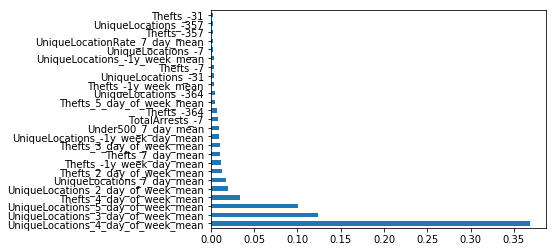

In [1351]:
feat_importances = pd.Series(model.feature_importances_, index=px.columns)
feat_importances = feat_importances.nlargest(25)
feat_importances.plot(kind='barh')

In [1341]:
NOW+relativedelta(years=-5, weekday=NOW.weekday())

datetime.datetime(2013, 3, 17, 16, 18, 9, 522847)

In [1342]:
NOW+relativedelta(days=-1820)

datetime.datetime(2013, 3, 17, 16, 18, 9, 522847)

In [1365]:
px = px.merge(weather, left_index=True, right_index=True, how='inner')

In [1367]:
px.head()

,Thefts_-2,Thefts_-3,Thefts_-4,Thefts_-5,Thefts_-6,Thefts_-7,Thefts_-8,Thefts_-9,Thefts_-10,Thefts_-11,...,UniqueLocationRate_-371,UniqueLocationRate_-1y_week_day_mean,UniqueLocationRate_-1y_week_mean,UniqueLocationRate_7_day_mean,UniqueLocationRate_2_day_of_week_mean,UniqueLocationRate_3_day_of_week_mean,UniqueLocationRate_4_day_of_week_mean,UniqueLocationRate_5_day_of_week_mean,PRCP,TEMP
2002-01-07,202.0,206.0,211.0,266.0,344.0,222.0,165.0,217.0,226.0,195.0,...,0.955556,0.923675,0.921344,0.944723,0.908384,0.919839,0.921062,0.930265,0.0,83.5
2002-01-08,175.0,202.0,206.0,211.0,266.0,344.0,222.0,165.0,217.0,226.0,...,0.963801,0.938598,0.924263,0.947760,0.973630,0.956300,0.942835,0.942353,0.0,86.5
2002-01-09,217.0,175.0,202.0,206.0,211.0,266.0,344.0,222.0,165.0,217.0,...,0.920354,0.917466,0.922512,0.942821,0.917852,0.909881,0.921258,0.924408,0.0,71.0
2002-01-10,221.0,217.0,175.0,202.0,206.0,211.0,266.0,344.0,222.0,165.0,...,0.925926,0.934711,0.916658,0.942532,0.955596,0.950397,0.938691,0.936027,0.0,73.5
2002-01-11,250.0,221.0,217.0,175.0,202.0,206.0,211.0,266.0,344.0,222.0,...,0.950382,0.929155,0.927364,0.945641,0.944325,0.941223,0.945656,0.948751,0.0,37.5
